In [1]:
def update_dict(d, key, row):
    empty = [0 for _ in row]
    d[key] = (
        int(row[0]) + d.get(key, 0)
    )
    
def get_pair(gender):
    if gender == 'm' or gender == 'f':
        return 'focal'
    if gender == 'nm' or gender == 'nf':
        return 'neighbour'
    assert false
    
def get_position(position):
    if position == 'A' or position == 'D':
        return 'AD'
    elif position == 'B' or position == 'C':
        return 'BC'
    assert False, position

class CrazyKey:
    def __init__(self, phase, position, cond, *args):
        self.phase = phase
        self.position = get_position(position)
        self.original_position = position
        self.cond = cond
        self.args = args
        
    def __eq__(self, other):
        return self.args == other.args and self.position == other.position
    
    def __hash__(self):
        return hash((self.args, self.position))
    
    def __str__(self):
        return f'{self.phase} & {self.original_position} & {self.cond} & {self.args}'

# in order to signal whether the subtraction has been done or not, the value is an int 
# if the second value has been seen, and a string if it has.
def combine(crazy_dict, key, app):
    assert type(crazy_dict) is dict
    assert type(key) is CrazyKey
    assert type(app) is int

    try:
        (old_key, old_app) = crazy_dict[key]
        if old_key.phase == 'habituation' and key.phase == 'experiment':
            val = old_app - app
            # assert val >= 0, f'{k} -> {val}'
            return (old_key, f'{val}')

        if old_key.phase == 'experiment' and key.phase == 'habituation':
            val = app - old_app
            # assert val >= 0, f'{k} -> {val}'
            return (key, f'{val}')
        
        assert False, f'{old_key} f{key}'
        
    except KeyError:
        # Other entry not found yet, save app_i
        return (key, app)

In [2]:
names = ['habituation_control', 'experiment_control', 'habituation_treatment', 'experiment_treatment']
dicts = [dict() for _ in range(4)]
app_i_dict = dict()
app_n_dict = dict()

with open('intruder_tests_corrected_pair_id.csv','r') as f:
    import csv
    reader = csv.reader(f)
    for row in reader:
        # skip header
        if row[0] == 'tank_num':
            continue

        try:
            tank_num = row[0].strip()
            date = row[1].strip()
            position = row[2].strip()
            pair_id = int(row[3])
            status = row[4].strip()
            phase = row[5].strip()
            cond = row[6].strip()
            gender = row[7].strip()

            if status == 'F':
                pass
            elif status == 'S':
                continue
            else:
                assert False, f'{status} is not a valid status!'
            
            if tank_num == 'F6A' and date == '2017.04.28' and position == 'A':
                # print(f'Skip: {row}')
                continue

            (key, val) = combine(
                app_i_dict,
                CrazyKey(phase, position, cond, pair_id, gender), 
                int(row[8]))
            app_i_dict[key] = (key, val)

            (key, val) = combine(
                app_n_dict,
                CrazyKey(phase, position, cond, pair_id, gender), 
                int(row[9]))
            app_n_dict[key] = (key, val)
                        
            pair = get_pair(gender)
            phase_cond = f'{phase}_{cond}'
            assert phase_cond in names, phase_cond
            
            key = (tank_num, date, position, pair, pair_id)

            #if pair_id == 1 or pair_id == 2:
            update_dict(dicts[names.index(phase_cond)], key, row[8:10])

        except ValueError as e:
            print(f'Skipping: {e}, {row}')
            pass

print('app_i_dict:')
for k,v in app_i_dict.items():
    if type(v[1]) is not str:
        print(f'Not processed? {k}')
    else:
        print(f'{k} -> {v[1]}')

print('\napp_n_dict:')
for k,v in app_n_dict.items():
    if type(v[1]) is not str:
        print(f'Not processed? {k}')
    else:
        print(f'{k} -> {v[1]}')
    
#for i,d in enumerate(dicts):
    # print(f'Dict: {names[i]}')
    # for k,v in d.items():
       # print(f'{k} -> {v}')

Skipping: invalid literal for int() with base 10: 'NA', ['F6A', '2017.04.28', 'B', '11', 'F', 'habituation', 'control', 'm', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA']
Skipping: invalid literal for int() with base 10: 'NA', ['F6A', '2017.04.28', 'B', '11', 'F', 'habituation', 'control', 'f', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA']
app_i_dict:
habituation & A & control & (2, 'nm') -> -7
habituation & A & control & (2, 'nf') -> -7
experiment & A & control & (2, 'm') -> 15
experiment & A & control & (2, 'f') -> 1
habituation & B & control & (2, 'nm') -> -12
habituation & B & control & (2, 'nf') -> 2
experiment & B & control & (2, 'm') -> 10
experiment & B & control & (2, 'f') -> 18
habituation & A & control & (3, 'm') -> -13
habituation & A & control & (3, 'f') -> -8
experiment & A & control & (3, 'nm') -> 0
experiment & A & control & (3, 'nf') -> 1
habituation & B & control & (3, 'm') -> 7
habituation & B & control & (3, 'f') -

In [3]:
combined = list()

In [4]:
def plot_combined(crazy_dict):
    a = [int(v[1]) for k, v in crazy_dict.items() if k.cond == 'control']
    b = [int(v[1]) for k, v in crazy_dict.items() if k.cond == 'treatment']

    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.boxplot(
        [a, b],
        labels=['control', 'treatment'],
        # positions=[1, 3]
    )
    # ax.set(ylabel='approaches per fortnight', title=f'{names[i]}')
    # ax.set_ylim(0, 160)

    from scipy import stats
    print(stats.mannwhitneyu(a, b))
    combined.append([(k.args, v[1]) for k, v in crazy_dict.items() if k.cond == 'control'])
    combined.append([(k.args, v[1]) for k, v in crazy_dict.items() if k.cond == 'treatment'])

In [5]:
plot_combined(app_i_dict)

MannwhitneyuResult(statistic=12497.0, pvalue=0.3558320541242421)


MannwhitneyuResult(statistic=11825.5, pvalue=0.08455877527906225)


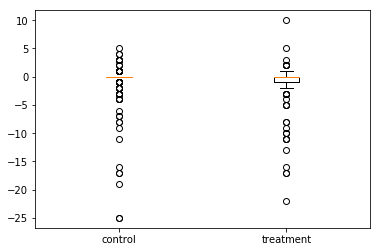

In [6]:
plot_combined(app_n_dict)

In [7]:
def special_output(x):
    return f'{x[0][0]}, {x[0][1]}, {x[1]}'

print('pair_id, gender, control i, treatment i, control n, treatment n')
for (a, b, c, d) in zip(combined[0], combined[1], combined[2], combined[3]):
    print(f'{special_output(a)}, {special_output(b)}, {c}, {d}')

pair_id, gender, control i, treatment i, control n, treatment n
2, nm, -7, 5, m, 4, ((2, 'nm'), '0'), ((5, 'm'), '0')
2, nf, -7, 5, f, -11, ((2, 'nf'), '0'), ((5, 'f'), '0')
2, m, 15, 5, m, 27, ((2, 'm'), '0'), ((5, 'm'), '0')
2, f, 1, 5, f, 25, ((2, 'f'), '0'), ((5, 'f'), '0')
2, nm, -12, 5, nm, 0, ((2, 'nm'), '0'), ((5, 'nm'), '0')
2, nf, 2, 5, nf, 2, ((2, 'nf'), '0'), ((5, 'nf'), '-1')
2, m, 10, 5, nm, 0, ((2, 'm'), '0'), ((5, 'nm'), '0')
2, f, 18, 5, nf, 0, ((2, 'f'), '0'), ((5, 'nf'), '2')
3, m, -13, 7, nm, 0, ((3, 'm'), '3'), ((7, 'nm'), '0')
3, f, -8, 7, nf, 0, ((3, 'f'), '3'), ((7, 'nf'), '0')
3, nm, 0, 7, nm, -4, ((3, 'nm'), '0'), ((7, 'nm'), '0')
3, nf, 1, 7, nf, 0, ((3, 'nf'), '3'), ((7, 'nf'), '0')
3, m, 7, 7, m, -1, ((3, 'm'), '0'), ((7, 'm'), '-2')
3, f, 18, 7, f, -5, ((3, 'f'), '0'), ((7, 'f'), '0')
3, nm, 2, 7, m, -2, ((3, 'nm'), '1'), ((7, 'm'), '0')
3, nf, 12, 7, f, -4, ((3, 'nf'), '0'), ((7, 'f'), '0')
10, nm, 0, 17, m, 17, ((10, 'nm'), '1'), ((17, 'm'), '-3')
10, nf

In [8]:
for d in dicts:
    a_focal = [v for k,v in d.items() if k[2] == 'A' and k[3] == 'focal']
    b_focal = [v for k,v in d.items() if k[2] == 'B' and k[3] == 'focal']
    c_focal = [v for k,v in d.items() if k[2] == 'C' and k[3] == 'focal']
    d_focal = [v for k,v in d.items() if k[2] == 'D' and k[3] == 'focal']
    a_neighbour = [v for k,v in d.items() if k[2] == 'A' and k[3] == 'neighbour']
    b_neighbour = [v for k,v in d.items() if k[2] == 'B' and k[3] == 'neighbour']
    c_neighbour = [v for k,v in d.items() if k[2] == 'C' and k[3] == 'neighbour']
    d_neighbour = [v for k,v in d.items() if k[2] == 'D' and k[3] == 'neighbour']
    b_all = [b_f + b_n for b_f, b_n in zip(b_focal, b_neighbour)]
    c_all = [c_f + c_n for c_f, c_n in zip(c_focal, c_neighbour)]
    print(f'{len(a_focal)}, {len(b_focal)}, {len(c_focal)}, {len(d_focal)}')
    print(f'{len(a_neighbour)}, {len(b_neighbour)}, {len(c_neighbour)}, {len(d_neighbour)}')
    print(f'{len(b_all)}, {len(c_all)}')

9, 9, 10, 10
10, 10, 10, 10
9, 10
10, 10, 10, 10
10, 10, 10, 10
10, 10
6, 6, 14, 14
14, 14, 6, 6
6, 6
14, 14, 6, 6
6, 6, 14, 14
6, 6


In [9]:
from scipy import stats
import numpy

In [10]:
#    a_neighbour = [v for k,v in dicts[i].items() if k[2] == 'A' and k[3] == 'neighbour']
#    b_neighbour = [v for k,v in dicts[i].items() if k[2] == 'B' and k[3] == 'neighbour']
#    c_neighbour = [v for k,v in dicts[i].items() if k[2] == 'C' and k[3] == 'neighbour']
#    d_neighbour = [v for k,v in dicts[i].items() if k[2] == 'D' and k[3] == 'neighbour']

#print(f'{len(a_focal)}, {len(b_focal)}, {len(c_focal)}, {len(d_focal)}')
    #print(f'{len(a_neighbour)}, {len(b_neighbour)}, {len(c_neighbour)}, {len(d_neighbour)}')
    #print(f'{len(b_all)}, {len(c_all)}')
    #ssert len(a_focal) == len(b_focal), f'{len(a_focal)} {len(b_focal)}'
    #fst = stats.wilcoxon(a_focal, b_focal)
    #snd = stats.wilcoxon(a_focal, b_all)
    #thd = stats.wilcoxon(c_focal, d_focal)
    #fot = stats.wilcoxon(c_all, d_focal)
    #print(f'Af vs Bf: {fst}')
    #print(f'Af vs Ba: {snd}')
    #print(f'Cf vs Df: {thd}')
    #print(f'Ca vs Df: {fot}')

In [11]:
def generate_boxplot_data(i):
    a_focal = [v for k,v in dicts[i].items() if k[2] == 'A' and k[3] == 'focal']
    b_focal = [v for k,v in dicts[i].items() if k[2] == 'B' and k[3] == 'focal']
    c_focal = [v for k,v in dicts[i].items() if k[2] == 'C' and k[3] == 'focal']
    d_focal = [v for k,v in dicts[i].items() if k[2] == 'D' and k[3] == 'focal']
    b_all = [b_f + b_n for b_f, b_n in zip(b_focal, b_neighbour)]
    c_all = [c_f + c_n for c_f, c_n in zip(c_focal, c_neighbour)]
    return a_focal, b_focal, c_focal, d_focal, b_all, c_all

def do_plot(idxs):
    import matplotlib.pyplot as plt

    data_points = [list() for _ in range(6)]
    for i in idxs:
        results = generate_boxplot_data(i)
        for j, new_points in enumerate(results):
            data_points[j] += new_points
        
    print(f'{",".join([str(len(d)) for d in data_points])}')
    fig, ax = plt.subplots()
    ax.boxplot(
        data_points,
        labels=['A', 'B', 'B all', 'C all', 'C', 'D'],
        positions=[1, 3, 3.75, 5.25, 6, 8]
    )
    ax.set(ylabel='attacks per 2 min', title=f'{" + ".join([names[i] for i in idxs])}')
    ax.set_ylim(0, 160)

9,9,10,10,6,10


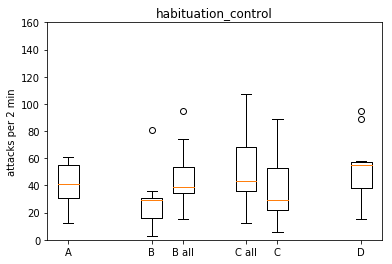

In [12]:
do_plot([0])

15,15,24,24,12,24


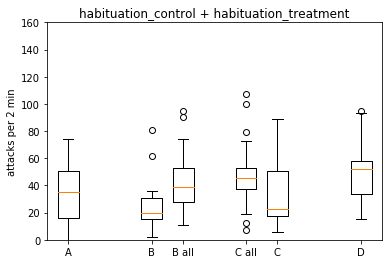

In [13]:
do_plot([0,2])

10,10,10,10,6,10


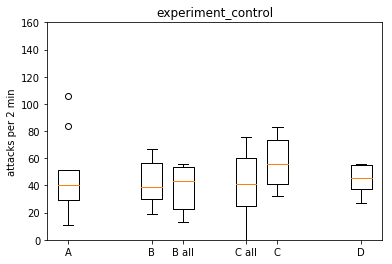

In [14]:
do_plot([1])

14,14,6,6,6,6


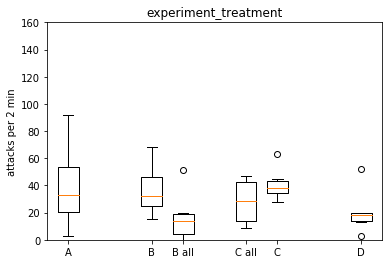

In [15]:
do_plot([3])